In [131]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from libs.XY_model import XYSystem
import cv2
from tqdm import tqdm

In [132]:
def get_curl(x, neighbors):    
    N = x.shape[0]
    curl = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            for a in range(1, neighbors):
                curl[i, j] += (  ( (2 * sin(x[i, j]) - sin(x[i, (j+a)%N] - sin(x[i, (j-a)%N])))) -
                                ( (2 * cos(x[i, j])) - cos(x[(i+a)%N, j]) - cos(x[(i-a)%N, j]))   )/a
                curl[i, j] += (  ( (2 * sin(x[i, j]) - sin(x[(i+a)%N, (j+a)%N] - sin(x[(i-a)%N, (j-a)%N])))) -
                                ( (2 * cos(x[i, j])) - cos(x[(i+a)%N, (j+a)%N]) - cos(x[(i-a)%N, (j-a)%N]))   )/(a * (2**0.5))
    curl /= neighbors
    return curl

In [133]:
def find_local_ext(x):
    N = x.shape[0]
    maxima = []
    maxim_cu = np.zeros([N, N])
    minima = []
    minim_cu = np.zeros([N, N])
    a = 1
    for i in range(N):
        for j in range(N):
            if(x[i, j] < x[(i+a)%N, j] and x[i, j] < x[(i-a)%N, j] and
            x[i, j] < x[(i+a)%N, (j+a)%N] and x[i, j] < x[(i-a)%N, (j-a)%N] and 
            x[i, j] < x[i, (j+a)%N] and x[i, j] < x[i, (j-a)%N]):
                minima.append([i, j])
                minim_cu[i, j] = x[i, j]
            if(x[i, j] > x[(i+1)%N, j] and x[i, j] > x[(i-1)%N, j] and
            x[i, j] > x[(i+1)%N, (j+1)%N] and x[i, j] > x[(i-1)%N, (j-1)%N] and 
            x[i, j] > x[i, (j+1)%N] and x[i, j] > x[i, (j-1)%N]):
                maxima.append([i, j])
                maxim_cu[i, j] = x[i, j]
    return np.array(maxima), np.array(minima), maxim_cu, minim_cu

In [134]:
def find_distribution(cu, min_loc, max_loc, max_dist, bins = 200):
    p = np.zeros(bins)
    c = np.zeros(bins)
    dr = (max_dist  / (bins - 1))
    for i in range(max_loc.shape[0]):
        for j in range(min_loc.shape[0]):
            d = ((max_loc[i, 0] - min_loc[j, 0])**2 + (max_loc[i, 1] - min_loc[j, 1])**2)**(0.5)
            r = (int) (d / dr)
            p[r] += 1
            c[r] += abs(cu[max_loc[i, 0], max_loc[i, 1]] * cu[min_loc[j, 0], min_loc[j, 1]])
    p /= (sum(p) * dr)
    c /= (sum(c) * dr)
    return p, c

In [135]:
def list2matrix(S):
        N=int(np.size(S))
        L = int(np.sqrt(N))
        S=np.reshape(S,(L,L))
        return S

In [136]:
def plot_heatmap(spin_config, curl, temp, name = 'result', heat = True, just_heat = False):
    N = spin_config.shape[0]
    plt.figure(figsize=(4,4),dpi=800, facecolor='white')
    if(heat):
        plt.imshow(curl, extent=(0, N, 0, N))
        plt.colorbar()
    if(just_heat):
        plt.imshow(curl,extent=(0, N, 0, N))
        plt.colorbar()
        plt.savefig(f'./images/{name}.png', dpi = 800)
        plt.close()
        return
    X, Y = np.meshgrid(np.arange(0,N),np.arange(0, N))
    U = np.cos(spin_config)
    V = np.sin(spin_config)
    Q = plt.quiver(X, Y, U, V, units='width')
    qk = plt.quiverkey(Q, 0.1, 0.1, 1, r'$spin$', labelpos='E',
                coordinates='figure')
    plt.title('T=%.2f'%temp+', #spins='+str(N)+'x'+str(N))
    plt.savefig(f'./images/{name}.png', dpi = 800)
    plt.close()

In [137]:
def do_monte_carlo(temp, N):
    xy = XYSystem(temperature = temp, width = N)
    xy.equilibrate(show=False)
    return list2matrix(xy.spin_config)

In [138]:
temp = [0.2, 0.6, 0.89, 1.2, 1.6]
N = 32
ensemble = 1
bins = 100
P_r = []
C_r = []

In [139]:
for i in tqdm(range(len(temp))):
    p = np.zeros(bins)
    c = np.zeros(bins)
    for e in range(ensemble):
        x = do_monte_carlo(temp[i], N)
        cu = get_curl(x, (int)(x.shape[0]/5))
        maxima, minima, max_cu, min_cu = find_local_ext(cu)
        pp, cc = find_distribution(cu, minima, maxima, ((N**2) + (N**2))**(0.5), bins)
        p += pp
        c += cc
    p /= ensemble
    c /= ensemble
    # plt.plot(p, label = f'Temp_{temp[i]}')
    P_r.append(p)
    C_r.append(c)
        # plot_heatmap(x, cu, temp[i], f'mix_{temp[i]}_{N[n]}')
        # plot_heatmap(x, max_cu, temp[i], f'maxima_{temp[i]}_{N[n]}', False, True)
        # plot_heatmap(x, min_cu, temp[i], f'minima_{temp[i]}_{N[n]}', False, True)
        # plot_heatmap(x, cu, temp[i], f'vec_{temp[i]}_{N[n]}', False)
        # plot_heatmap(x, cu, temp[i], f'curl_{temp[i]}_{N[n]}', False, True)
# plt.legend();

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-134-45c9fb1784ab>:11: RuntimeWarning: invalid value encountered in true_divide
  p /= (sum(p) * dr)
<ipython-input-134-45c9fb1784ab>:12: RuntimeWarning: invalid value encountered in true_divide
  c /= (sum(c) * dr)
100%|██████████| 5/5 [01:39<00:00, 19.93s/it]


In [140]:
p_r = np.array(P_r)
c_r = np.array(C_r)

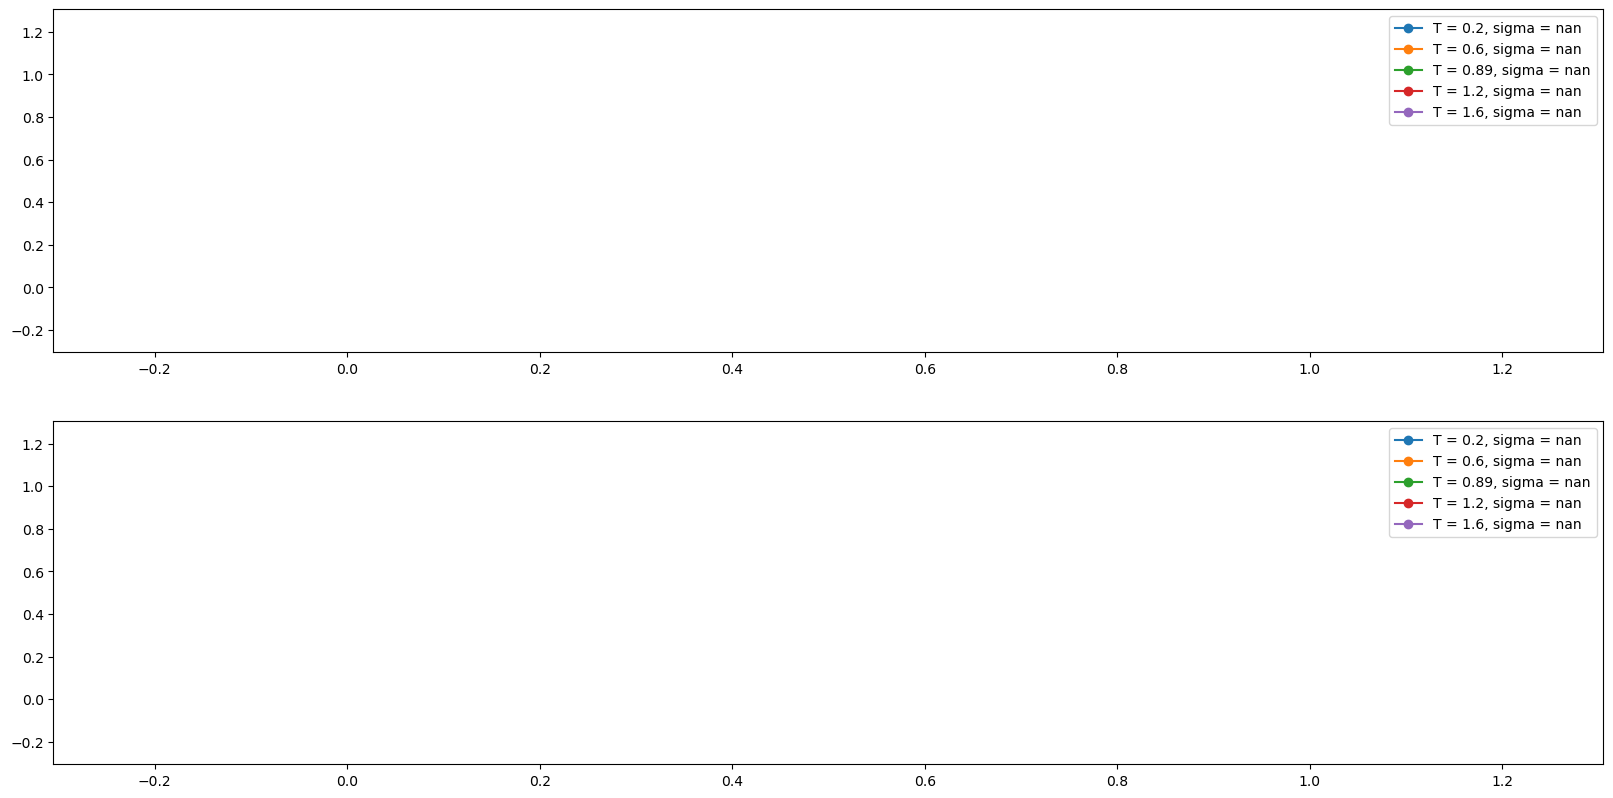

In [141]:
fig1, ax1 = plt.subplots(2, figsize=(20, 10), dpi = 100)

for i in range(len(temp)):
    ax1[0].plot(p_r[i, :], '-o',label = f'T = {temp[i]}, sigma = {np.std(p_r[i, :])}')
    ax1[1].plot(c_r[i, :], '-o',label = f'T = {temp[i]}, sigma = {np.std(c_r[i, :])}')
ax1[0].legend()
ax1[1].legend();

In [142]:
# a = np.array([[2, 0, 0, 2, 2],
#               [2, 2, 2, 5, 2],
#               [2, 2, 2, 2, 2],
#               [2, 2, 2, 2, 2],
#               [2, 2, 2, 2, 2]])

In [143]:
# find_local_ext(a)

In [144]:
maxima.shape[0]

0